In [1]:
import matplotlib.pyplot as plt
import math
import matplotlib.cm as cm
import scipy.constants
from math import pi, isinf
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

import warnings
warnings.filterwarnings("ignore")

font = {'family': 'serif', 'size': 16}
plt.rc('font', **font)
plt.rc('text', usetex=True)

# Constants kb in the unit of kj/mol
GAS_CONSTANT = 8.314462618 * 10**(-3)

# Using S0 method to compute the activity coeffients of ethanol & water at varying mole fractions.

# The chemical potential is calculated from
$$
\left(\frac{\partial \mu_A}{\partial \ln x_A}\right)_{T, P}=\frac{k_B T}{x_B S_{A A}^0 + x_A S_{B B}^0 -  2 \sqrt{x_A x_B} S_{A B}^0}
$$
### in which the error estimation for this integrand is based on:
$$
\sigma_{\rm{integrand}} = \sqrt{\frac{x_A^2 \sigma_{S_{A A}}^2 + 4 x_A x_B  \sigma_{S_{A B}}^2 + x_B^2 \sigma_{S_{B B}}^2}{(x_A {S_{A A}} + x_B {S_{B B}}  -  2 \sqrt{x_A x_B} S_{A B}^0)^4}}
$$

## Since the activity coeffients $\gamma$ takes the form of:
$$
\gamma = \frac{e^{\frac{\mu}{k_{\rm B} T}}}{x}
$$
### so that the error propogation in computing $\gamma$ becomes 
$$
\sigma_{\gamma}  = \sigma_{\mu} \frac{\gamma}{k_{\rm B} x}
$$


In [2]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import quad


def get_betadmua_dlnxa(saa: float, sab: float, sbb: float, xa: float) -> float:
    """
    Calculate the derivative of beta_mu_a with respect to ln(x_a).

    Parameters:
    saa (float): Parameter S_AA
    sab (float): Parameter S_AB
    sbb (float): Parameter S_BB
    xa (float): Mole fraction of component A

    Returns:
    float: The derivative of beta_mu_a with respect to ln(x_a)
    """
    xb = 1.0 - xa
    return 1.0 / (xb * saa + xa * sbb - 2 * (xa * xb) ** 0.5 * sab)

def mu_mol_frac(saa: np.ndarray, sab: np.ndarray, sbb: np.ndarray, xa: np.ndarray, x0: float, kbT: float) -> np.ndarray:
    """
    Calculate the integral of a function and its error.

    Parameters:
    saa, sab, sbb (np.ndarray): 2D arrays with shape (2, N), where the first row is S and the second row is S_error.
    xa (np.ndarray): 1D array with N elements.
    x0 (float): A constant.
    kbT (float): Boltzmann constant times temperature.

    Returns:
    np.ndarray: A 2D array where each row is [x_a, mu, mu_error].
    """
    logxa = np.log(xa)

    integrand = get_betadmua_dlnxa(saa[:,0],sab[:,0],sbb[:,0],xa)
    integrand_error = np.sqrt((xa**2*saa[:,1]**2 + 4*xa*(1-xa)*sab[:,1]**2 + 
                               (1-xa)**2*sbb[:,1]**2)/(xa*saa[:,0] + (1-xa)*sbb[:,0] - 2*sab[:,0]*(xa*(1-xa))**0.5)**4)   

    mask = ~np.isnan(integrand)
    int_func = interp1d(logxa[mask], integrand[mask], kind='linear',fill_value='extrapolate')
    int_error_func = interp1d(logxa[mask], integrand_error[mask], kind='linear',fill_value='extrapolate')

    # Calculate the integral using list comprehension
    x_mu_dataset = []
    for i, a in enumerate(logxa):
        mu_now = kbT * quad(int_func, np.log(x0), a)[0]
        mu_error_now = kbT * quad(int_error_func, np.log(x0), a)[0]
        mu_error_now /= np.sqrt(i) if i >= 1 else 1
        x_mu_dataset.append([xa[i], mu_now, abs(mu_error_now)])
    
    return np.asarray(x_mu_dataset)

def read_data(file_path: str) -> tuple:
    """
    Read a data file and extract several columns into numpy arrays.

    Parameters:
    file_path (str): The path to the data file.

    Returns:
    tuple: A tuple containing numpy arrays for x_eth, x_water, S_AA, S_AB, and S_BB.
    """
    data = pd.read_csv(file_path, sep=' ', skiprows=9, 
                       names=["x", "AA", "AA_err", "AB", "AB_err", "BB", "BB_err"], engine='python')
    x_eth = data['x'].values
    x_water = 1 - x_eth

    S_AA = data[['AA', 'AA_err']].values
    S_AB = data[['AB', 'AB_err']].values
    S_BB = data[['BB', 'BB_err']].values
    
    return x_eth, x_water, S_AA, S_AB, S_BB
    

def process_data_gamma(file_path: str, T: float) -> tuple:
    """
    Process data from a file and calculate gamma values.

    Parameters:
    file_path (str): The path to the data file.
    T (float): Temperature.

    Returns:
    tuple: A tuple containing numpy arrays for x_eth, gamma_eth_sum, and gamma_water_sum.
    """
    x_eth, x_water, S_AA, S_AB, S_BB = read_data(file_path)

    kbT = GAS_CONSTANT * T 
    excess_mu_eth_part = mu_mol_frac(S_AA, S_AB, S_BB, x_eth, 1, kbT)
    excess_mu_water_part = mu_mol_frac(S_BB, S_AB, S_AA, x_water, 1, kbT)

    # Calculate gamma and gamma_err in a single step
    gamma_eth, gamma_eth_err = np.exp(excess_mu_eth_part[:, 1] / kbT) / x_eth, excess_mu_eth_part[:, 2] / kbT * np.exp(excess_mu_eth_part[:, 1] / kbT)
    gamma_eth_sum = np.column_stack((gamma_eth, gamma_eth_err))
    
    gamma_water, gamma_water_err = np.exp(excess_mu_water_part[:, 1] / kbT) / x_water, excess_mu_water_part[:, 2] / kbT * np.exp(excess_mu_water_part[:, 1] / kbT)
    gamma_water_sum = np.column_stack((gamma_water, gamma_water_err))
    
    return x_eth, gamma_eth_sum, gamma_water_sum

Now we include the part of vapor pressure 
The vapor pressure at any given temeperature is 

$$ \sqrt{\frac{\left(H^{2} T^{2} \sigma_{T b}^{2} + T_{b}^{2} \sigma_{H}^{2} \left(T - T_{b}\right)^{2}\right) e^{\frac{2 H \left(T - T_{b}\right)}{R T T_{b}}}}{R^{2} T^{2} T_{b}^{4}}} $$

In [3]:
####


DeltaH_eth =  39.60 # kJ/mol
DeltaH_eth_error = 2.09
Tb_eth = 344.68 # K
Tb_eth_error = 1.16 


DeltaH_water =  51.35 # kJ/mol
DeltaH_water_error = 1.03
Tb_water = 397.73 # K
Tb_water_error = 1.31 # 
######
#DeltaH_eth =  42.3 # kJ/mol
#DeltaH_eth_error = 0.4
#Tb_eth = 351.5 # K
#Tb_eth_error = 0.2



#DeltaH_water =  40.65 # kJ/mol
#DeltaH_water_error = 0.0 
#Tb_water = 373.15
#Tb_water_error = 0.0 # 

def cal_P_vapor_eth(T):
    P_vap  = math.exp(DeltaH_eth / GAS_CONSTANT * (1/Tb_eth - 1/T)) 
    P_vap_err = math.sqrt(((DeltaH_eth**2*Tb_eth_error**2*T**2+DeltaH_eth_error**2*Tb_eth**2*(Tb_eth-T)**2)*P_vap**2)/(GAS_CONSTANT**2*T**2*Tb_eth**4))
    return  P_vap, P_vap_err

def cal_P_vapor_water(T):
    P_vap  = math.exp(DeltaH_water / GAS_CONSTANT * (1/Tb_water - 1/T)) 
    P_vap_err = math.sqrt(((DeltaH_water**2*Tb_water_error**2*T**2+DeltaH_water_error**2*Tb_water**2*(Tb_water-T)**2)*P_vap**2)/(GAS_CONSTANT**2*T**2*Tb_water**4))
    return  P_vap, P_vap_err


In [4]:
temperatures = [347, 350, 351, 352, 355, 360, 365, 367, 368, 370]
file_paths = [f"/Users/xiaoyuwang/Downloads/GitHub/MD simulation for chemcial potential/NPT results/Ethanol + water mixture: Trappe-UA ethanol + Tip4p-ew water/Gromacs results/Liq_{T}K_1bar_gmx_trappeUA.txt" for T in temperatures]

kbK_2_kjmol = 8.314462618*10**(-3)

# Use dictionary comprehension to store the results
x_eth_dataset = {}
y_eth_dataset = {}

gamma_eth_dataset = {}
gamma_water_dataset = {}

mu_eth_gas_dataset = {}
mu_eth_liq_dataset = {}

mu_water_gas_dataset = {}
mu_water_liq_dataset = {}

mu_water_liq_ideal = {}
mu_eth_liq_ideal = {}

# Loop over each temperature and file path
for T, file_path in zip(temperatures, file_paths):
      x_eth_dp, gamma_eth_dp, gamma_water_dp = process_data_gamma(file_path, T)
      x_eth_dataset[T] = x_eth_dp
      gamma_eth_dataset[T] = np.log(gamma_eth_dp)*T
      gamma_water_dataset[T] =  np.log(gamma_water_dp)*T

      mu_eth_gas_dataset[T] = kbK_2_kjmol*T*np.log(x_eth_dp)
      mu_eth_liq_dataset[T] = kbK_2_kjmol*T*np.log(gamma_eth_dp[:,0]*x_eth_dp) + DeltaH_eth*(T/Tb_eth-1)
      mu_eth_liq_ideal[T] =  kbK_2_kjmol*T*np.log(x_eth_dp) + DeltaH_eth*(T/Tb_eth-1)

      mu_water_liq_dataset[T] = kbK_2_kjmol*T*np.log(gamma_water_dp[:,0]*(1-x_eth_dp)) + DeltaH_water*(T/Tb_water-1)    
      mu_water_gas_dataset[T] = kbK_2_kjmol*T*np.log((1-x_eth_dp))
      mu_water_liq_ideal[T] =  kbK_2_kjmol*T*np.log((1-x_eth_dp)) + DeltaH_water*(T/Tb_water-1) 

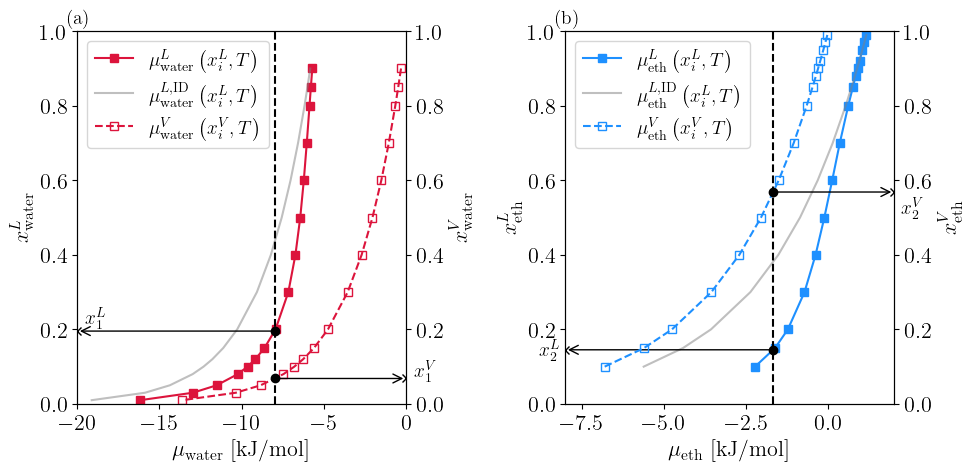

In [13]:
# Create a figure with two subplots (ax1 and ax2), and set the figure size to 10x5 inches
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Set a temperature value
Temp = 355

# Create a second y-axis for the first subplot
ax12 = ax1.twinx()

# Plot two lines on the first subplot (ax1) and one line on the second y-axis (ax12)
ax1.plot( mu_water_liq_dataset[Temp], 1-x_eth_dataset[Temp], marker='s', c='crimson', ls = "-", label=r"$\mu_{\rm{water}}^L\left(x_i^L, T\right)$" )
ax1.plot( mu_water_liq_ideal[Temp], 1-x_eth_dataset[Temp], marker='none', alpha = 0.5, c='grey', ls = "-", label=r"$\mu_{\rm{water}}^{L, \rm{ID}}\left(x_i^L, T\right)$" )
ax12.plot(mu_water_gas_dataset[Temp], 1-x_eth_dataset[Temp], marker='s', markerfacecolor='None', c='crimson', ls = "--", label=r"$\mu_{\rm{water}}^V\left(x_i^V, T\right)$" )

# Create interpolation functions for the two lines plotted on ax1 and ax12
f1 = interp1d(mu_water_liq_dataset[Temp],1-x_eth_dataset[Temp])
f2 = interp1d(mu_water_gas_dataset[Temp], 1-x_eth_dataset[Temp])

# Use the interpolation functions to find the y-values at x=-5
x_var=-8
x1 = f1(x_var)
y1 = f2(x_var)

# Plot the intersection points on ax1 and ax12, and draw a vertical line at x=-5
ax1.set_xlim(-20, 0)
ax1.plot(x_var, x1, 'ko')
ax12.plot(x_var, y1, 'ko')
ax1.axvline(x=x_var, color='black', linestyle='--')

# Add arrows and labels to the intersection points
ax1.annotate('', xy=(-20, x1), xytext=(x_var, x1), arrowprops=dict(arrowstyle='->',facecolor='black'))
ax12.annotate('', xy=(0, y1), xytext=(x_var, y1), arrowprops=dict(arrowstyle='->',facecolor='black'))
ax1.plot(-20, x1, 'kx', zorder=10)  
ax1.text(-19.5, x1*1.1, f'$x_1^L$', fontsize=14)
ax12.plot(0, y1, 'kx', zorder=10)
ax1.text(0.5, y1*1.1, f'$x_1^V$', fontsize=14)

# Set the labels for the x and y axes
ax1.set_xlabel(r'$\mu_{\rm{water}}$ [kJ/mol]')
ax1.set_ylabel(r'$x_{\rm{water}}^{L}$')
ax12.set_ylabel(r'$x_{\rm{water}}^{V}$')

# Get the legend items and labels from ax1 and ax12, combine them, and create a new legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax12.get_legend_handles_labels()
lines = lines1 + lines2
labels = labels1 + labels2
ax1.legend(lines, labels, fontsize=14, loc='upper left', )
ax1.text(-0.03, 1.02, '(a)', transform=ax1.transAxes, size=14)

# The code then repeats a similar process for the second subplot (ax2 and ax22)

# Finally, it sets the y-axis limits for all subplots to be between 0 and 1, adjusts the width space between the subplots, applies a tight layout, and displays the figure
ax1.set_ylim(0, 1)
ax12.set_ylim(0, 1)
ax2.set_ylim(0, 1)
ax22.set_ylim(0, 1)
plt.subplots_adjust(wspace=0.5)
plt.tight_layout()
plt.show()

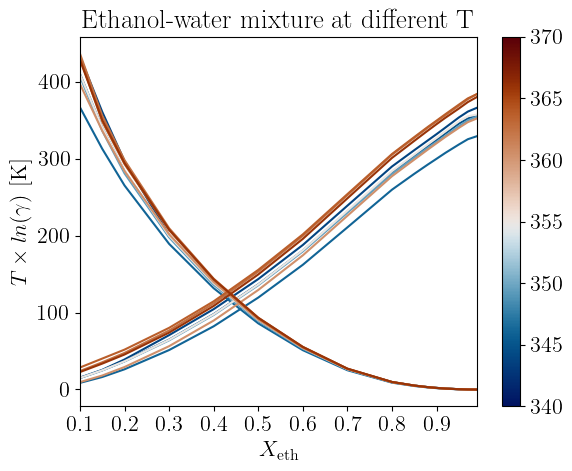

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

fig, ax = plt.subplots()


cm_data = np.loadtxt("/Users/xiaoyuwang/Software/ScientificColourMaps7/vik/vik.txt")
vik_map = LinearSegmentedColormap.from_list('vik', cm_data)

def color_coord(Temp, Temp_set):
    lowest_T = min(Temp_set)*0.99
    highest_T = max(Temp_set)*1.01 
    T_scale = (Temp - lowest_T) / (highest_T - lowest_T)
    color_index = int(len(cm_data) * T_scale)
    color_coord = cm_data[color_index].tolist()
    return color_coord

colors = cm.rainbow(np.linspace(0, 1, len(temperatures)))

sm = plt.cm.ScalarMappable(cmap=vik_map, norm=plt.Normalize(vmin=min(temperatures), vmax=max(temperatures)))
sm.set_array([])


temperatures = [ 350, 351, 352, 355, 360, 365, 367, 368, 370]




# 对于每一个温度，绘制 gamma_eth 和 gamma_water 作为 x_eth 的函数
for T, color in zip(temperatures, colors):
    ax.plot(x_eth_dataset[T], gamma_eth_dataset[T][::,0], color=color_coord(T,temperatures), label=f'gamma_eth at T={T}')
    ax.plot(x_eth_dataset[T], gamma_water_dataset[T][::,0], color=color_coord(T,temperatures), label=f'gamma_water at T={T}')
    



plt.xticks(np.arange(0, 1.1, step=0.1))
plt.margins(x=0)
plt.ylabel(r"$ T \times ln(\gamma) $ [K]")
plt.xlabel("$X_\mathrm{eth}$ ")
plt.title("Ethanol-water mixture at different T")
fig.colorbar(sm, ax=ax)

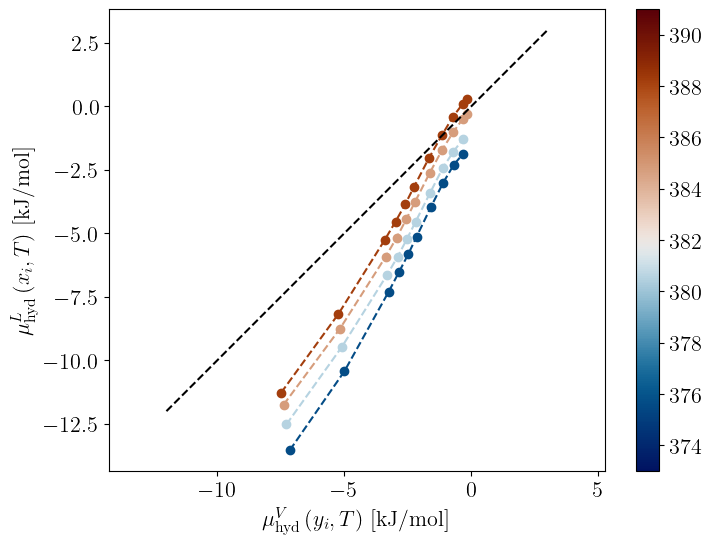

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from matplotlib.colors import LinearSegmentedColormap




cm_data = np.loadtxt("/Users/xiaoyuwang/Software/ScientificColourMaps7/vik/vik.txt")
vik_map = LinearSegmentedColormap.from_list('vik', cm_data)


def color_coord(Temp, Temp_set):
    lowest_T = min(Temp_set)*0.99
    highest_T = max(Temp_set)*1.01 
    T_scale = (Temp - lowest_T) / (highest_T - lowest_T)
    color_index = int(len(cm_data) * T_scale)
    color_coord = cm_data[color_index].tolist()
    return color_coord

temperatures = [373, 380, 386, 391]
file_paths = [f"/Users/xiaoyuwang/Downloads/GitHub/Hydrazine Water Mix/N2H4_water_opls_{T}.txt" for T in temperatures]


colors = cm.rainbow(np.linspace(0, 1, len(temperatures)))

sm = plt.cm.ScalarMappable(cmap=vik_map, norm=plt.Normalize(vmin=min(temperatures), vmax=max(temperatures)))
sm.set_array([])




# Use dictionary comprehension to store the results
x_hyd_dataset = {}
gamma_hyd_dataset = {}
gamma_water_dataset = {}
mu_hyd_gas_dataset ={}
mu_hyd_liq_dataset ={}

DeltaH_hyd = 44.5 # kJ/mol
DeltaH_hyd_error = 0.0
Tb_hyd = 386.95 # K
Tb_hyd_error = 0.0

mu_water_gas_dataset = {}
mu_water_liq_dataset = {}


# Loop over each temperature and file path
for T, file_path in zip(temperatures, file_paths):
      x_hyd_dp, gamma_hyd_dp, gamma_water_dp = process_data_gamma(file_path, T)
      x_hyd_dataset[T] = x_hyd_dp
      gamma_hyd_dataset[T] = np.log(gamma_hyd_dp)*T
      gamma_water_dataset[T] =  np.log(gamma_water_dp)*T
      mu_hyd_gas_dataset[T] = kbK_2_kjmol*T*np.log(x_hyd_dp)
      mu_hyd_liq_dataset[T] = kbK_2_kjmol*T*np.log(gamma_hyd_dp[:,0]*x_hyd_dp) - DeltaH_hyd*(T/Tb_hyd-1)

      mu_water_liq_dataset[T] = kbK_2_kjmol*T*np.log(gamma_water_dp[:,0]*(1-x_hyd_dp)) - DeltaH_water*(T/Tb_water-1)    
      mu_water_gas_dataset[T] = kbK_2_kjmol*T*np.log(1-x_hyd_dp)

# 对于每一个温度，绘制 gamma_eth 和 gamma_water 作为 x_eth 的函数
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
for T in temperatures:
    ax.plot(mu_hyd_gas_dataset[T], mu_hyd_liq_dataset[T], marker='o', linestyle='--', color=color_coord(T, temperatures))

#plt.legend(title='Temperature (K)', loc='upper left')

# 1:1 line
x = np.linspace(-12, 3, 100)
y = x
ax.plot(x, y, linestyle='--', color='black')

plt.xlabel(r'$\mu_{\rm{hyd}}^V\left(y_i, T\right)$ [kJ/mol]')
plt.ylabel(r'$\mu_{\rm{hyd}}^L\left(x_i, T\right)$ [kJ/mol]')

#make the fig a square
plt.axis('equal')

fig.colorbar(sm, ax=ax)